# PPOのCriticネットワークを事前学習する

In [16]:
import os
import sys
from pathlib import Path
from typing import List, Optional, Tuple
import random
from dataclasses import dataclass
import copy

import torch
if torch.cuda.is_available():
    from torch.cuda.amp import autocast, GradScaler
else:
    from torch.amp import autocast, GradScaler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
import torchinfo
import optuna
from PIL import Image

from contextlib import nullcontext

project_root = Path.cwd().parent
sys.path.append(str(project_root))

# omnicampus環境との違い
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    BOARD_TRAIN_DIR = os.path.join("data", "egaroucid")
else:
    BOARD_TRAIN_DIR = os.path.join(project_root, "data", "egaroucid")


Using device: mps


## データセットの作成

In [17]:
def plot_board(board: np.ndarray, score: int):
    """
    1は青、-1は赤, 0は黒
    """
    cmap = ListedColormap(["#d62728", "#2f2f2f", "#1f77b4"])  # -1, 0, 1
    norm = BoundaryNorm([-1.5, -0.5, 0.5, 1.5], cmap.N)

    im = plt.imshow(board, cmap=cmap, norm=norm)
    cbar = plt.colorbar(im, ticks=[-1, 0, 1])
    cbar.ax.set_yticklabels(["-1", "0", "1"])

    plt.title(f"Board, score: {score}")
    plt.show()

In [18]:
board_npy = np.load(os.path.join(BOARD_TRAIN_DIR, "boards.npy"))
score_npy = np.load(os.path.join(BOARD_TRAIN_DIR, "scores.npy"))
print(board_npy.shape, score_npy.shape)

(10000, 8, 8) (10000,)


In [19]:
# 1万個のみにランダムに選択
seed = 42
np.random.seed(seed)
rand_idx = np.random.choice(len(board_npy), size=10000, replace=False)
board_npy = board_npy[rand_idx]
score_npy = score_npy[rand_idx]
print(board_npy.shape, score_npy.shape)

(10000, 8, 8) (10000,)


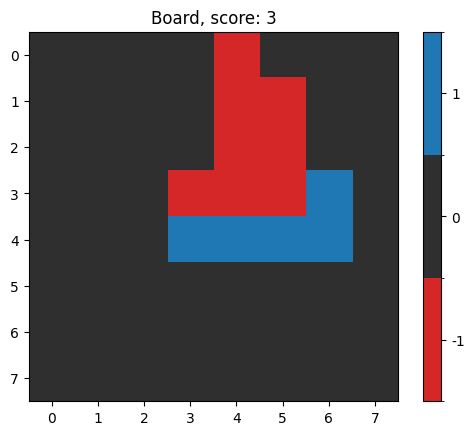

In [20]:
rand_idx = random.randint(0, len(board_npy) - 1)
plot_board(board_npy[rand_idx], score_npy[rand_idx])

In [21]:
class OthelloDataset(Dataset):
    def __init__(self, boards: np.ndarray, scores: np.ndarray, transform: Optional[T.Compose] = None) -> None:
        super().__init__()
        self.boards = boards
        self.scores = scores
        self.transform = transform

    def __len__(self) -> int:
        return len(self.boards)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        board = torch.from_numpy(self.boards[idx]).unsqueeze(0)
        if self.transform:
            board = self.transform(board)
        score = torch.tensor(self.scores[idx], dtype=torch.float32)
        return board, score

In [22]:
# scoreは、-64~64の範囲なので、-1~1の範囲に正規化する
score_npy = score_npy / 64.0

# board_npyとscore_npyをtrain, valid, testに分割して、それぞれのデータセットを作成する
# 70%をtrain, 15%をvalid, 15%をtestとする
train_boards = board_npy[: int(len(board_npy) * 0.7)]
train_scores = score_npy[: int(len(score_npy) * 0.7)]
val_boards = board_npy[int(len(board_npy) * 0.7) : int(len(board_npy) * 0.85)]
val_scores = score_npy[int(len(score_npy) * 0.7) : int(len(score_npy) * 0.85)]
test_boards = board_npy[int(len(board_npy) * 0.85) :]
test_scores = score_npy[int(len(score_npy) * 0.85) :]

# データ拡張として、上下左右反転を追加する
transform = T.Compose([
    T.RandomVerticalFlip(p=0.5),
    T.RandomHorizontalFlip(p=0.5),
])

# データセットを作成する
train_dataset = OthelloDataset(train_boards, train_scores, transform)
val_dataset = OthelloDataset(val_boards, val_scores)
test_dataset = OthelloDataset(test_boards, test_scores)

In [23]:
print(train_dataset[0])

(tensor([[[ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0, -1,  0,  1,  0,  0],
         [ 0,  0,  0, -1, -1, -1,  0,  0],
         [ 0,  0,  0, -1, -1, -1,  0,  0],
         [ 0, -1,  1,  1, -1,  1,  1,  0],
         [ 0,  1,  1,  1, -1, -1,  0,  0],
         [ 0,  0,  0,  0,  0, -1,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0]]]), tensor(0.))


0.0


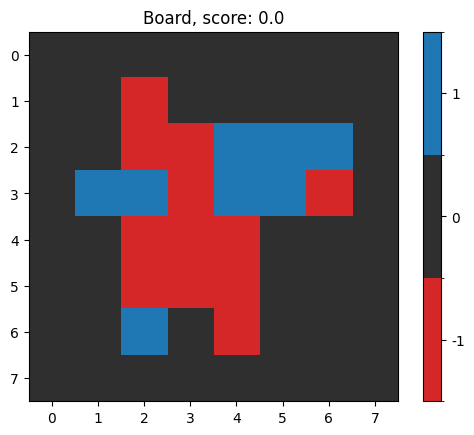

In [24]:
print(train_scores[0])

board_np = train_dataset[0][0].squeeze().numpy()
score_np = train_dataset[0][1].numpy()
plot_board(board_np, score_np)

## Criticアーキテクチャの定義

In [25]:
class ResBlock(nn.Module):
    def __init__(self, ch: int, bn_eps: float = 1e-5, zero_init: bool = True):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(ch, eps=bn_eps)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(ch, eps=bn_eps)
        if zero_init:
            # 出力を初期は恒等写像に近づけて安定化
            nn.init.zeros_(self.bn2.weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = F.relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return F.relu(x + h)

class CriticNet(nn.Module):
    def __init__(
        self,
        in_ch: int = 2,
        width: int = 32,
        num_res_blocks: int = 3,
        bn_eps: float = 1e-5,
        head_hidden_size: int = 32,
        use_gap: bool = True,
        norm_head: str = "ln",
    ):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, width, 3, padding=1, bias=False),
            nn.GroupNorm(1, width, eps=bn_eps),
            nn.ReLU(inplace=True),
        )
        self.res_blocks = nn.Sequential(
            *[ResBlock(width, bn_eps=bn_eps, zero_init=True) for _ in range(num_res_blocks)]
        )

        # value head: 1x1 conv → (norm) → ReLU
        self.value_conv = nn.Conv2d(width, 1, kernel_size=1, bias=False)

        if norm_head == "bn":
            self.value_norm = nn.GroupNorm(1, 1, eps=bn_eps)
        elif norm_head == "ln":
            # LayerNorm over (C,H,W) = (1,8,8) -> normalized_shape=(1,8,8)
            self.value_norm = nn.LayerNorm((1, 8, 8))
        elif norm_head == "gn":
            self.value_norm = nn.GroupNorm(1, 1)  # 1 group = LayerNorm的
        else:
            self.value_norm = nn.Identity()

        self.use_gap = use_gap
        if use_gap:
            in_fc = 1  # GAPで(1,)に
        else:
            in_fc = 8 * 8

        self.value_fc1 = nn.Linear(in_fc, head_hidden_size)
        self.value_fc2 = nn.Linear(head_hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.stem(x)
        h = self.res_blocks(h)

        h = self.value_conv(h)  # (B,1,8,8)
        if isinstance(self.value_norm, nn.LayerNorm):
            h = self.value_norm(h)  # 形状そのまま
        else:
            h = self.value_norm(h)
        h = F.relu(h)

        if self.use_gap:
            h = h.mean(dim=(2, 3), keepdim=False)  # (B,1)
        else:
            h = h.view(h.size(0), -1)             # (B,64)

        h = F.relu(self.value_fc1(h))
        v = torch.tanh(self.value_fc2(h))         # [-1, 1]
        return v  # (B,1)

In [26]:
dummy_input = torch.randn(4, 2, 8, 8)
torchinfo.summary(CriticNet(), input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
CriticNet                                [4, 1]                    --
├─Sequential: 1-1                        [4, 32, 8, 8]             --
│    └─Conv2d: 2-1                       [4, 32, 8, 8]             576
│    └─GroupNorm: 2-2                    [4, 32, 8, 8]             64
│    └─ReLU: 2-3                         [4, 32, 8, 8]             --
├─Sequential: 1-2                        [4, 32, 8, 8]             --
│    └─ResBlock: 2-4                     [4, 32, 8, 8]             --
│    │    └─Conv2d: 3-1                  [4, 32, 8, 8]             9,216
│    │    └─BatchNorm2d: 3-2             [4, 32, 8, 8]             64
│    │    └─Conv2d: 3-3                  [4, 32, 8, 8]             9,216
│    │    └─BatchNorm2d: 3-4             [4, 32, 8, 8]             64
│    └─ResBlock: 2-5                     [4, 32, 8, 8]             --
│    │    └─Conv2d: 3-5                  [4, 32, 8, 8]             9,216
│    

## 学習

In [27]:
@dataclass
class TrainingConfig:
    """学習設定クラス。"""
    batch_size: int = 32
    lr: float = 1e-3
    weight_decay: float = 1e-5
    num_epochs: int = 10
    device: torch.device = (
        torch.device("mps") if torch.backends.mps.is_available()
        else torch.device("cuda") if torch.cuda.is_available()
        else torch.device("cpu")
    )
    warmup_epochs: int = 5
    min_lr: float = 1e-5
    stop_patience: int = 5
    seed: int = 42


class Trainer:
    """CUDA のときのみ混合精度を使用する学習クラス。"""

    def __init__(self, trial: optuna.Trial, config: TrainingConfig, model: nn.Module, train_loader: DataLoader, val_loader: DataLoader):
        self.trial = trial
        self.config = config
        self.model = model.to(self.config.device)
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=self.config.lr, weight_decay=self.config.weight_decay
        )

        # Cosine スケジューラ設定
        steps_per_epoch = len(train_loader)
        total_steps = steps_per_epoch * self.config.num_epochs
        warmup_steps = steps_per_epoch * self.config.warmup_epochs

        self.warmup = LinearLR(
            self.optimizer,
            start_factor=self.config.min_lr / self.config.lr,
            end_factor=1.0,
            total_iters=warmup_steps,
        )
        self.cosine = CosineAnnealingLR(
            self.optimizer,
            T_max=max(1, total_steps - warmup_steps),
            eta_min=self.config.min_lr,
        )
        self.scheduler = SequentialLR(
            self.optimizer,
            schedulers=[self.warmup, self.cosine],
            milestones=[warmup_steps],
        )

        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = nn.HuberLoss()

        # CUDA のときだけ AMP を使う
        self.scaler = GradScaler()

        self.best_val_loss = float("inf")
        self.best_model = None
        self.train_loss_history = []
        self.val_loss_history = []

    def train(self) -> tuple[float, nn.Module]:
        """学習を実行し、最良の検証損失とモデル重みを返す。"""
        pbar = tqdm(range(self.config.num_epochs), desc="Training")
        for epoch in pbar:
            epoch_train_loss = 0.0
            seen_samples = 0

            self.model.train()
            for boards, targets in self.train_loader:
                self.optimizer.zero_grad(set_to_none=True)

                boards = self._parse_2d(boards)
                boards = boards.to(self.config.device, non_blocking=(self.config.device.type == "cuda"))
                targets = targets.to(self.config.device, non_blocking=(self.config.device.type == "cuda"))

                # 前向き + 損失は AMP（CUDA のみ）で
                with autocast(device_type=self.config.device.type, dtype=torch.float16):
                    outputs = self.model(boards).squeeze()
                    loss = self.criterion(outputs, targets)

                # AMP: scale -> backward -> (unscaleしてclip) -> step -> update
                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()

                batch_size = boards.shape[0]
                epoch_train_loss += loss.item() * batch_size
                seen_samples += batch_size

            self.scheduler.step()

            train_loss = epoch_train_loss / max(1, seen_samples)
            self.train_loss_history.append(train_loss)

            # 検証（前向きは AMP を使っても OK）
            self.model.eval()
            val_losses = []
            with torch.no_grad():
                for boards, targets in self.val_loader:
                    boards = self._parse_2d(boards)
                    boards = boards.to(self.config.device, non_blocking=(self.config.device.type == "cuda"))
                    targets = targets.to(self.config.device, non_blocking=(self.config.device.type == "cuda"))
                    with autocast(device_type=self.config.device.type, dtype=torch.float16):
                        outputs = self.model(boards).squeeze()
                        loss = self.criterion(outputs, targets)
                    val_losses.append(loss.item())

            val_loss = sum(val_losses) / max(1, len(val_losses))
            self.val_loss_history.append(val_loss)

            if self.best_val_loss > val_loss:
                self.best_val_loss = val_loss
                self.best_model = copy.deepcopy(self.model.state_dict())

            pbar.set_postfix({"Epoch": epoch + 1, "Train Loss": train_loss, "Val Loss": val_loss})

            self.trial.report(val_loss, step=epoch)
            if self.trial.should_prune():
                raise optuna.TrialPruned()

        return self.best_val_loss, self.best_model

    def _parse_2d(self, boards: torch.Tensor) -> torch.Tensor:
        """入力を (B, 2, 8, 8) に変換し、2 プレーン目に符号反転した局面を格納する。"""
        if boards.dim() == 3:
            boards = boards.unsqueeze(1)
        if boards.size(1) != 1:
            raise ValueError(f"期待する形状は (B, 1, 8, 8) ですが: {boards.shape}")
        boards = boards.float()
        inverted = -boards
        return torch.cat([boards, inverted], dim=1)

    def plot_loss_history(self):
        """学習と検証の損失履歴をプロットする。"""
        plt.figure(figsize=(6, 3))
        plt.plot(self.train_loss_history, label="Train Loss")
        plt.plot(self.val_loss_history, label="Val Loss")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()
        plt.show()
        plt.close()

In [28]:
def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

[I 2025-09-25 09:48:42,349] Using an existing study with name 'critic_study' instead of creating a new one.
/Users/mori/dev/othello-with-rl/rl_agent/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Training:   0%|          | 0/58 [00:00<?, ?it/s]

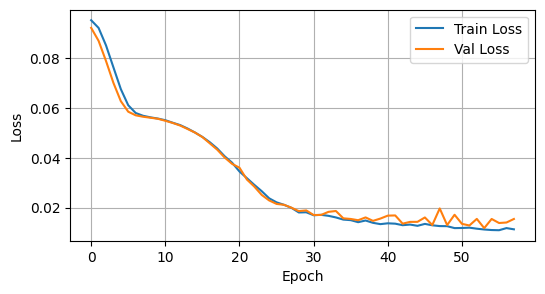

[I 2025-09-25 09:49:27,486] Trial 12 finished with value: 0.011814084990570942 and parameters: {'lr': 0.008591474430948673, 'weight_decay': 2.3230459523960678e-05, 'num_epochs': 58, 'batch_size': 260}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/69 [00:00<?, ?it/s]

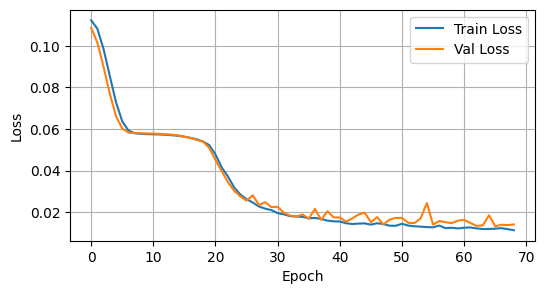

[I 2025-09-25 09:50:30,132] Trial 13 finished with value: 0.013183524211247763 and parameters: {'lr': 0.00894647097302056, 'weight_decay': 2.9659307074530532e-05, 'num_epochs': 69, 'batch_size': 264}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/87 [00:00<?, ?it/s]

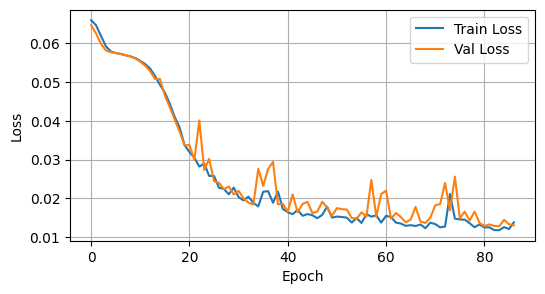

[I 2025-09-25 09:51:57,900] Trial 14 finished with value: 0.012771800005187591 and parameters: {'lr': 0.008139302563605235, 'weight_decay': 4.047689931108358e-05, 'num_epochs': 87, 'batch_size': 259}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/93 [00:00<?, ?it/s]

[I 2025-09-25 09:52:18,349] Trial 15 pruned. 


Training:   0%|          | 0/126 [00:00<?, ?it/s]

[I 2025-09-25 09:53:00,093] Trial 16 pruned. 


Training:   0%|          | 0/79 [00:00<?, ?it/s]

[I 2025-09-25 09:53:20,818] Trial 17 pruned. 


Training:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-09-25 09:53:41,268] Trial 18 pruned. 


Training:   0%|          | 0/87 [00:00<?, ?it/s]

/Users/mori/dev/othello-with-rl/rl_agent/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


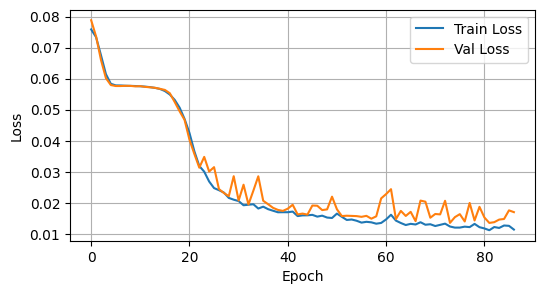

[I 2025-09-25 09:55:03,523] Trial 19 finished with value: 0.013526507653295994 and parameters: {'lr': 0.009314606535695148, 'weight_decay': 4.3471507532241485e-05, 'num_epochs': 87, 'batch_size': 471}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/129 [00:00<?, ?it/s]

[I 2025-09-25 09:55:25,450] Trial 20 pruned. 


Training:   0%|          | 0/29 [00:00<?, ?it/s]

[I 2025-09-25 09:55:47,438] Trial 21 pruned. 


Training:   0%|          | 0/68 [00:00<?, ?it/s]

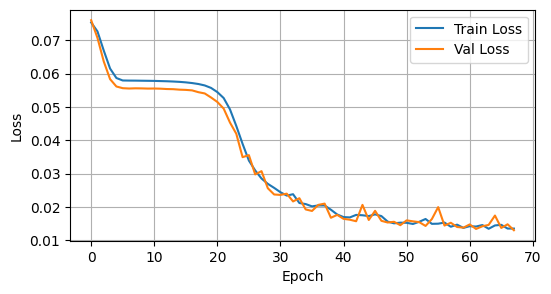

[I 2025-09-25 09:56:52,971] Trial 22 finished with value: 0.01295981959750255 and parameters: {'lr': 0.00993205936337996, 'weight_decay': 5.2713231637643855e-05, 'num_epochs': 68, 'batch_size': 296}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/53 [00:00<?, ?it/s]

[I 2025-09-25 09:57:09,675] Trial 23 pruned. 


Training:   0%|          | 0/79 [00:00<?, ?it/s]

[I 2025-09-25 09:57:25,226] Trial 24 pruned. 


Training:   0%|          | 0/69 [00:00<?, ?it/s]

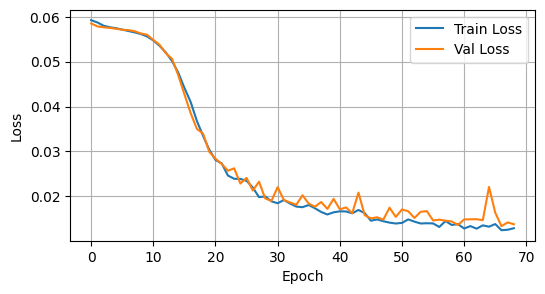

[I 2025-09-25 09:58:12,534] Trial 25 finished with value: 0.013381591532379389 and parameters: {'lr': 0.009958809443853892, 'weight_decay': 1.6864728448224707e-05, 'num_epochs': 69, 'batch_size': 421}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/103 [00:00<?, ?it/s]

[I 2025-09-25 09:58:42,391] Trial 26 pruned. 


Training:   0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-09-25 09:58:57,617] Trial 27 pruned. 


Training:   0%|          | 0/80 [00:00<?, ?it/s]

[I 2025-09-25 09:59:13,684] Trial 28 pruned. 


Training:   0%|          | 0/46 [00:00<?, ?it/s]

[I 2025-09-25 09:59:29,721] Trial 29 pruned. 


Training:   0%|          | 0/116 [00:00<?, ?it/s]

[I 2025-09-25 09:59:52,058] Trial 30 pruned. 


Training:   0%|          | 0/84 [00:00<?, ?it/s]

[I 2025-09-25 10:00:06,764] Trial 31 pruned. 


Training:   0%|          | 0/70 [00:00<?, ?it/s]

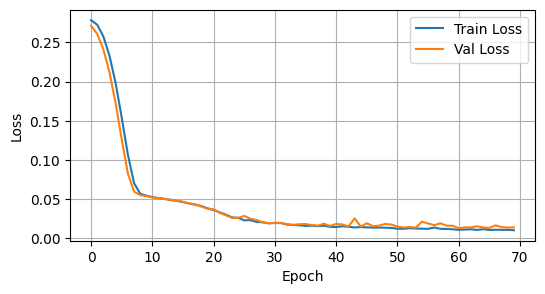

[I 2025-09-25 10:01:01,038] Trial 32 finished with value: 0.012892522693922123 and parameters: {'lr': 0.007588032900389095, 'weight_decay': 2.74247420254396e-05, 'num_epochs': 70, 'batch_size': 261}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/62 [00:00<?, ?it/s]

[I 2025-09-25 10:01:27,672] Trial 33 pruned. 


Training:   0%|          | 0/72 [00:00<?, ?it/s]

[I 2025-09-25 10:01:53,188] Trial 34 pruned. 


Training:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-09-25 10:02:33,644] Trial 35 pruned. 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

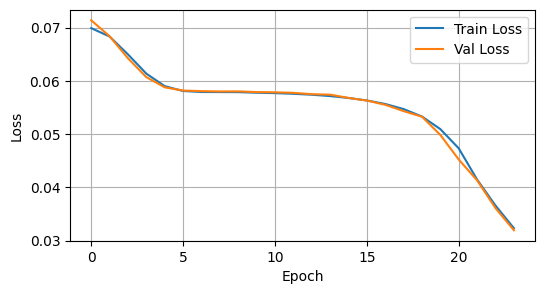

[I 2025-09-25 10:02:58,819] Trial 36 finished with value: 0.031938927620649336 and parameters: {'lr': 0.006690317923715336, 'weight_decay': 0.00016926114683473836, 'num_epochs': 24, 'batch_size': 305}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/57 [00:00<?, ?it/s]

[I 2025-09-25 10:03:21,305] Trial 37 pruned. 


Training:   0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-09-25 10:03:49,277] Trial 38 pruned. 


Training:   0%|          | 0/71 [00:00<?, ?it/s]

[I 2025-09-25 10:04:06,986] Trial 39 pruned. 


Training:   0%|          | 0/89 [00:00<?, ?it/s]

[I 2025-09-25 10:04:32,051] Trial 40 pruned. 


Training:   0%|          | 0/43 [00:00<?, ?it/s]

[I 2025-09-25 10:04:56,188] Trial 41 pruned. 


Training:   0%|          | 0/67 [00:00<?, ?it/s]

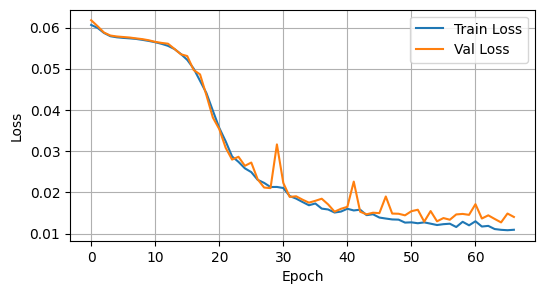

[I 2025-09-25 10:06:28,937] Trial 42 finished with value: 0.012698828397939602 and parameters: {'lr': 0.007797751747871244, 'weight_decay': 3.3276963419467926e-05, 'num_epochs': 67, 'batch_size': 286}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/65 [00:00<?, ?it/s]

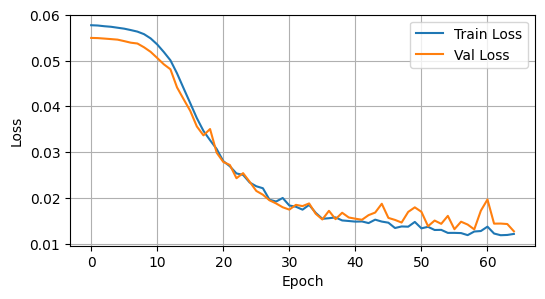

[I 2025-09-25 10:07:41,815] Trial 43 finished with value: 0.012679658209284147 and parameters: {'lr': 0.006518979904650418, 'weight_decay': 4.1761484049130045e-05, 'num_epochs': 65, 'batch_size': 296}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/75 [00:00<?, ?it/s]

[I 2025-09-25 10:08:11,618] Trial 44 pruned. 


Training:   0%|          | 0/64 [00:00<?, ?it/s]

[I 2025-09-25 10:08:32,513] Trial 45 pruned. 


Training:   0%|          | 0/54 [00:00<?, ?it/s]

[I 2025-09-25 10:08:53,153] Trial 46 pruned. 


Training:   0%|          | 0/12 [00:00<?, ?it/s]

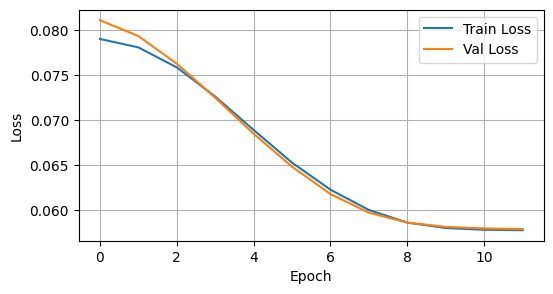

[I 2025-09-25 10:09:06,474] Trial 47 finished with value: 0.05790135636925697 and parameters: {'lr': 0.00412895506580989, 'weight_decay': 9.899591044371269e-05, 'num_epochs': 12, 'batch_size': 511}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-09-25 10:09:30,602] Trial 48 pruned. 


Training:   0%|          | 0/34 [00:00<?, ?it/s]

[I 2025-09-25 10:09:52,315] Trial 49 pruned. 


Training:   0%|          | 0/83 [00:00<?, ?it/s]

[I 2025-09-25 10:10:13,385] Trial 50 pruned. 


Training:   0%|          | 0/109 [00:00<?, ?it/s]

[I 2025-09-25 10:10:33,746] Trial 51 pruned. 


Training:   0%|          | 0/64 [00:00<?, ?it/s]

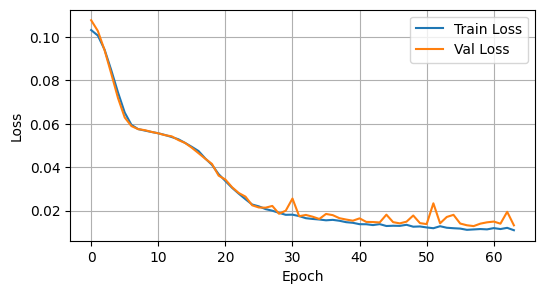

[I 2025-09-25 10:11:56,682] Trial 52 finished with value: 0.012810079380869865 and parameters: {'lr': 0.009802312335062425, 'weight_decay': 5.034925417041624e-05, 'num_epochs': 64, 'batch_size': 286}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/65 [00:00<?, ?it/s]

[I 2025-09-25 10:12:21,937] Trial 53 pruned. 


Training:   0%|          | 0/75 [00:00<?, ?it/s]

[I 2025-09-25 10:12:40,773] Trial 54 pruned. 


Training:   0%|          | 0/90 [00:00<?, ?it/s]

[I 2025-09-25 10:12:57,496] Trial 55 pruned. 


Training:   0%|          | 0/56 [00:00<?, ?it/s]

[I 2025-09-25 10:13:11,803] Trial 56 pruned. 


Training:   0%|          | 0/48 [00:00<?, ?it/s]

[I 2025-09-25 10:13:27,654] Trial 57 pruned. 


Training:   0%|          | 0/76 [00:00<?, ?it/s]

[I 2025-09-25 10:13:47,109] Trial 58 pruned. 


Training:   0%|          | 0/59 [00:00<?, ?it/s]

[I 2025-09-25 10:14:02,933] Trial 59 pruned. 


Training:   0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-09-25 10:14:18,492] Trial 60 pruned. 


Training:   0%|          | 0/51 [00:00<?, ?it/s]

[I 2025-09-25 10:14:33,099] Trial 61 pruned. 


Training:   0%|          | 0/67 [00:00<?, ?it/s]

[I 2025-09-25 10:14:50,724] Trial 62 pruned. 


Training:   0%|          | 0/67 [00:00<?, ?it/s]

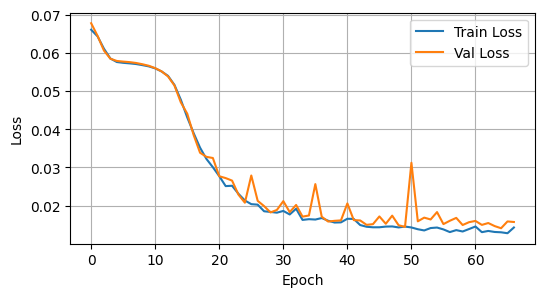

[I 2025-09-25 10:15:43,073] Trial 63 finished with value: 0.01408387627452612 and parameters: {'lr': 0.009943222832030132, 'weight_decay': 5.50441348048989e-05, 'num_epochs': 67, 'batch_size': 277}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

[I 2025-09-25 10:15:58,848] Trial 64 pruned. 


Training:   0%|          | 0/62 [00:00<?, ?it/s]

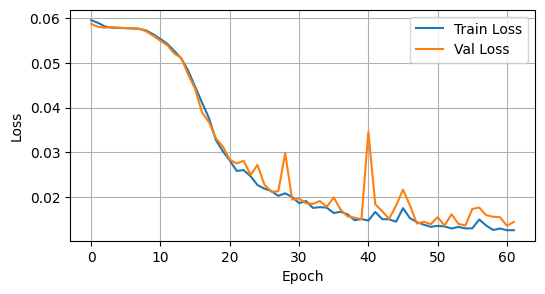

[I 2025-09-25 10:16:43,047] Trial 65 finished with value: 0.013581889681518078 and parameters: {'lr': 0.009766910608514184, 'weight_decay': 2.7544518658840874e-05, 'num_epochs': 62, 'batch_size': 348}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/71 [00:00<?, ?it/s]

[I 2025-09-25 10:16:57,425] Trial 66 pruned. 


Training:   0%|          | 0/80 [00:00<?, ?it/s]

[I 2025-09-25 10:17:11,945] Trial 67 pruned. 


Training:   0%|          | 0/92 [00:00<?, ?it/s]

[I 2025-09-25 10:17:27,678] Trial 68 pruned. 


Training:   0%|          | 0/58 [00:00<?, ?it/s]

[I 2025-09-25 10:17:44,314] Trial 69 pruned. 


Training:   0%|          | 0/74 [00:00<?, ?it/s]

[I 2025-09-25 10:17:59,160] Trial 70 pruned. 


Training:   0%|          | 0/45 [00:00<?, ?it/s]

[I 2025-09-25 10:18:21,566] Trial 71 pruned. 


Training:   0%|          | 0/69 [00:00<?, ?it/s]

[I 2025-09-25 10:18:38,081] Trial 72 pruned. 


Training:   0%|          | 0/78 [00:00<?, ?it/s]

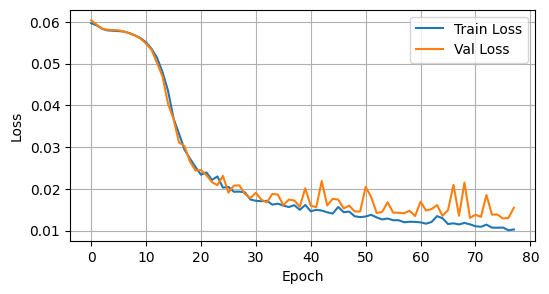

[I 2025-09-25 10:19:34,337] Trial 73 finished with value: 0.012921015173196793 and parameters: {'lr': 0.009833720667260988, 'weight_decay': 3.7404436497142396e-05, 'num_epochs': 78, 'batch_size': 308}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/86 [00:00<?, ?it/s]

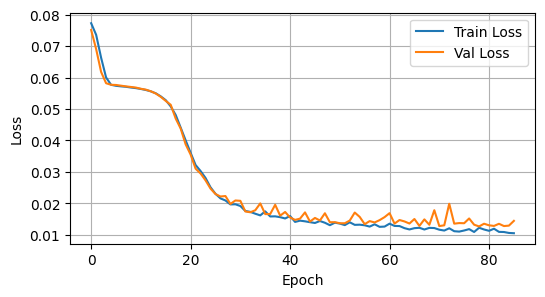

[I 2025-09-25 10:20:36,288] Trial 74 finished with value: 0.012657701224088668 and parameters: {'lr': 0.00993130867826012, 'weight_decay': 3.833083258575722e-05, 'num_epochs': 86, 'batch_size': 312}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-09-25 10:20:52,767] Trial 75 pruned. 


Training:   0%|          | 0/85 [00:00<?, ?it/s]

[I 2025-09-25 10:21:09,476] Trial 76 pruned. 


Training:   0%|          | 0/78 [00:00<?, ?it/s]

[I 2025-09-25 10:21:26,305] Trial 77 pruned. 


Training:   0%|          | 0/88 [00:00<?, ?it/s]

[I 2025-09-25 10:21:42,394] Trial 78 pruned. 


Training:   0%|          | 0/62 [00:00<?, ?it/s]

[I 2025-09-25 10:21:57,699] Trial 79 pruned. 


Training:   0%|          | 0/81 [00:00<?, ?it/s]

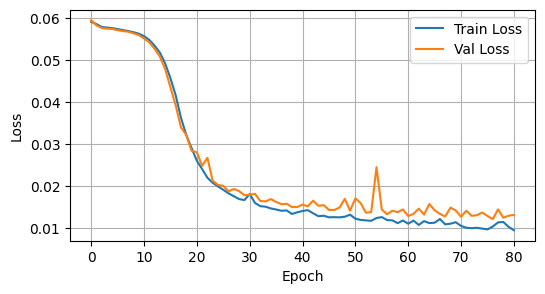

[I 2025-09-25 10:22:57,690] Trial 80 finished with value: 0.01214596132437388 and parameters: {'lr': 0.009979515905029488, 'weight_decay': 4.0490806622190035e-05, 'num_epochs': 81, 'batch_size': 280}. Best is trial 12 with value: 0.011814084990570942.


Training:   0%|          | 0/54 [00:00<?, ?it/s]

[I 2025-09-25 10:23:14,287] Trial 81 pruned. 


Training:   0%|          | 0/81 [00:00<?, ?it/s]

[I 2025-09-25 10:23:44,584] Trial 82 pruned. 


Training:   0%|          | 0/73 [00:00<?, ?it/s]

[I 2025-09-25 10:24:00,316] Trial 83 pruned. 


Training:   0%|          | 0/65 [00:00<?, ?it/s]

[I 2025-09-25 10:24:14,972] Trial 84 pruned. 


Training:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-09-25 10:24:29,230] Trial 85 pruned. 


Training:   0%|          | 0/77 [00:00<?, ?it/s]

[I 2025-09-25 10:24:46,136] Trial 86 pruned. 


Training:   0%|          | 0/94 [00:00<?, ?it/s]

[I 2025-09-25 10:25:03,603] Trial 87 pruned. 


Training:   0%|          | 0/87 [00:00<?, ?it/s]

[I 2025-09-25 10:25:20,476] Trial 88 pruned. 


Training:   0%|          | 0/82 [00:00<?, ?it/s]

[I 2025-09-25 10:25:35,643] Trial 89 pruned. 


Training:   0%|          | 0/71 [00:00<?, ?it/s]

[I 2025-09-25 10:25:49,653] Trial 90 pruned. 


Training:   0%|          | 0/64 [00:00<?, ?it/s]

[I 2025-09-25 10:26:06,491] Trial 91 pruned. 


Training:   0%|          | 0/78 [00:00<?, ?it/s]

[I 2025-09-25 10:26:23,134] Trial 92 pruned. 


Training:   0%|          | 0/69 [00:00<?, ?it/s]

[I 2025-09-25 10:26:43,436] Trial 93 pruned. 


Training:   0%|          | 0/51 [00:00<?, ?it/s]

[I 2025-09-25 10:26:59,321] Trial 94 pruned. 


Training:   0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-09-25 10:27:16,341] Trial 95 pruned. 


Training:   0%|          | 0/68 [00:00<?, ?it/s]

[I 2025-09-25 10:27:32,253] Trial 96 pruned. 


Training:   0%|          | 0/91 [00:00<?, ?it/s]

[I 2025-09-25 10:27:47,908] Trial 97 pruned. 


Training:   0%|          | 0/86 [00:00<?, ?it/s]

[I 2025-09-25 10:28:04,994] Trial 98 pruned. 


Training:   0%|          | 0/72 [00:00<?, ?it/s]

[I 2025-09-25 10:28:21,419] Trial 99 pruned. 


In [29]:
def objective(trial: optuna.Trial) -> float:
    # 探索範囲設定
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    num_epochs = trial.suggest_int("num_epochs", 10, 150)
    batch_size = trial.suggest_int("batch_size", 256, 1024)

    # config
    config = TrainingConfig(
        lr=lr,
        weight_decay=weight_decay,
        num_epochs=num_epochs,
        batch_size=batch_size,
    )

    # データローダーの作成
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        pin_memory=(config.device.type == "cuda"),
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        pin_memory=(config.device.type == "cuda"),
    )

    # モデル
    model = CriticNet()

    # 学習実行
    trainer = Trainer(trial, config, model, train_loader, val_loader)
    best_val_loss, _ = trainer.train()

    # ロスグラフの表示
    trainer.plot_loss_history()

    return best_val_loss


db_dir = "dbs"
os.makedirs(db_dir, exist_ok=True)
db_path = os.path.join(db_dir, "critic.db")

pruner = optuna.pruners.MedianPruner(
    n_startup_trials=5,
    n_warmup_steps=20,
    interval_steps=1,
)

 
study_name = "critic_study"
study = optuna.create_study(
    direction="minimize",
    pruner=pruner,
    sampler=optuna.samplers.TPESampler(seed=42),
    storage=f"sqlite:///{db_path}",
    study_name=study_name,
    load_if_exists=True,
)
study.optimize(objective, n_trials=100 - len(study.trials))

In [32]:
# データローダー（ベストパラメータ）
best_params = study.best_params
# 事前に作成済みの train_dataset / valid_dataset / test_dataset を利用
batch_size = int(best_params.get("batch_size", 64))

# MPSの場合はpin_memory=Falseが無難
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=False,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=False,
)

# モデル
model = CriticNet()

# TrainingConfig（ベストパラメータを適用）
config = TrainingConfig(
    lr=float(best_params.get("lr")),
    weight_decay=float(best_params.get("weight_decay")),
    num_epochs=int(best_params.get("num_epochs")),
    batch_size=batch_size,
)
print(config)

# 最終学習
trainer = Trainer(
    trial=optuna.trial.FixedTrial(best_params),  # ログ用にダミーTrialでも可
    config=config,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
)
final_best_val_loss, final_best_weights = trainer.train()
print("Final best val loss:", final_best_val_loss)

TrainingConfig(batch_size=260, lr=0.008591474430948673, weight_decay=2.3230459523960678e-05, num_epochs=58, device=device(type='mps'), warmup_epochs=5, min_lr=1e-05, stop_patience=5, seed=42)


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Final best val loss: 0.013320956534395615


In [31]:
# 保存ディレクトリ作成
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)

# ファイル名（タイムスタンプ付き）
import time
import json

ts = time.time()
weight_path = os.path.join(models_dir, f"criticnet_{ts}.pt")
meta_path = os.path.join(models_dir, f"criticnet_{ts}.json")

# 重み保存（state_dict）
torch.save(final_best_weights, weight_path)
print(f"Saved weights to: {weight_path}")

# メタ情報保存（ハイパラ・成績・データ形状など）
metadata = {
    "study_name": str(study_name),
    "db_path": str(db_path),
    "best_val_loss": float(final_best_val_loss),
    "best_params": str(best_params),
    "config": {
        "lr": config.lr,
        "weight_decay": config.weight_decay,
        "num_epochs": config.num_epochs,
        "batch_size": config.batch_size,
        "device": str(config.device),
        "warmup_epochs": config.warmup_epochs,
        "min_lr": config.min_lr,
        "stop_patience": config.stop_patience,
        "seed": config.seed,
    },
    "model_class": "CriticNet",
    "timestamp": ts,
}
with open(meta_path, "w") as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)
print(f"Saved metadata to: {meta_path}")

Saved weights to: models/criticnet_1758763747.929779.pt
Saved metadata to: models/criticnet_1758763747.929779.json
